## <h3 style="text-align: center;"><b> PyTorch's computation graphs  </b>

PyTorch performs its computations based on a **directed acyclic graph (DAG)**. \
The graph is called computation graph: nodes in the graph are Tensors, and edges are functions that produce output Tensors from input Tensors.\
PyTorch builds computation graph on the fly and uses it to derive the relationships between tensors and easily compute the gradients.


#### Computation graph implementing the equation ``y = log((w * x) + b)``

## <h3 style="text-align: center;"><b> Creating a graph in PyTorch</b>

In [12]:
import torch 

# create tensors
x = torch.tensor(1.)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build computation graph
y = torch.log((x * w) + b)

# Compute gradients
y.backward()

# Print gradients
print("dy/dw:", w.grad)
print("dy/db",  b.grad)

dy/dw: tensor(0.2000)
dy/db tensor(0.2000)


## <h3 style="text-align: center;"><b> Computation graph and Neural Networks</b>

Neural networks (NNs) are a collection of nested functions that transform the input data.\
These functions are defined by parameters (weights and biases), which in PyTorch are stored in tensors.\
In PyTorch special tensors are used to store and update the parameters of our model during training.\
To create such a tensor simply set ``requires_grad`` attribute to ``True``. By default a tensor is created with ``requires_grad = False``.

In [3]:
w.requires_grad_()        # w = torch.rand(1, requires_grad = True)
b.requires_grad_()        # b = torch.ones(1, requires_grad = True)

tensor([1.], requires_grad=True)

Using a computation graph PyTorch decomposes the network computation into a set of simpler functions.\
Computational graphs is at the core of the Neural Network training, which happens in two steps:
* a forward pass: the NN runs the input data through each of its functions to make the best guess about the correct output.
* a backward pass: propagate the error signal through the network, by means of gradients and adjust the model parameters accordingly. 


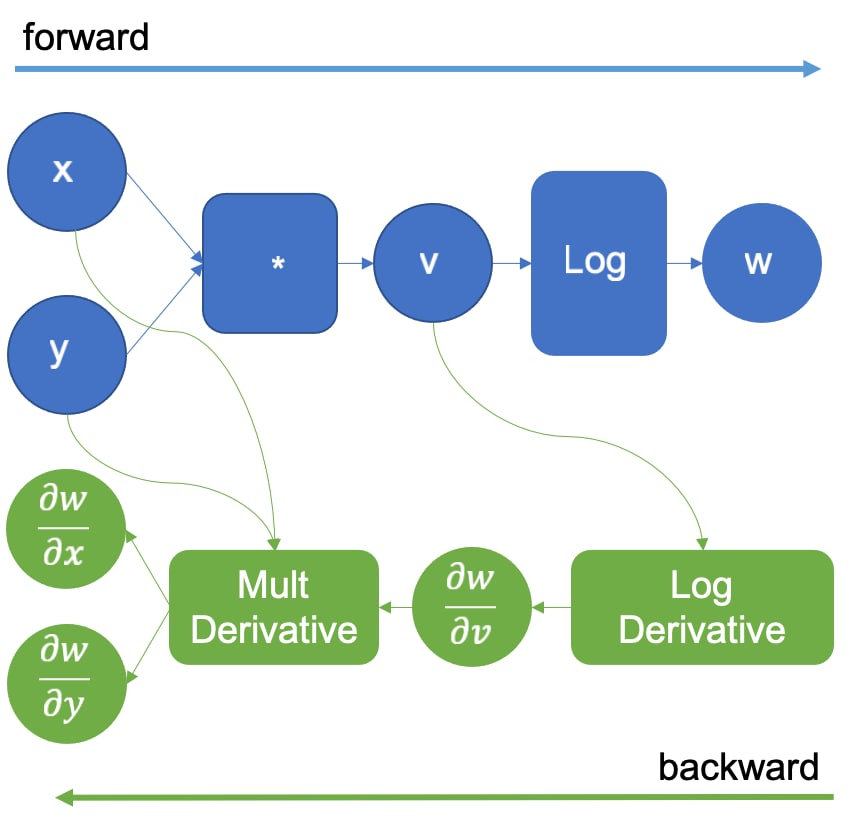

## <h3 style="text-align: center;"><b> Automatic differentiation </b>

Optimizing NNs requires computing the gradients of the loss with respect to the NN weights. \
PyTorch supports *automatic differentiation*, which can be thought of as an implementation of the *chain rule* for computing gradients of nested functions.\
Using PyTorch’s automatic differentiation, the forward pass of your network will define a computational graph.\
After the forward pass, the graph can be traversed backwards to calculate the gradients starting from the result of the forward evaluation.\
By calling ``backward`` method, we can compute the gradients of a tensor with respect to its dependent leaf nodes.

In [6]:
# compute gradients
y.backward()

print("dy/dw:", w.grad)
print("dy/db",  b.grad)

dy/dw: tensor(0.2000)
dy/db tensor(0.2000)


## <h3 style="text-align: center;"><b>  Supervised gradient-based learning  </b>


To perform a supervised learning we need 3 components (apart form the training data, i.e. input-target pairs):
* a **model** that computes predictions from the observed input features 
* a **loss function** that informs how far off the model's guess is from the correct answer (the target)
* an **optimizer** that makes the appropriate adjustement to the model's parameters, trying to align its predictions to the correct answer.

The learning starts with mistakes. We use an appropriate loss function to tell us how far off the model's predictions are from the correct answer. \
Having computed the prediction error, we propagate it through the network **[Backpropagation]**. To do this, we compute the gradient of the loss function with respect to the parameters of the model. The gradient signals *"how much"* the parameters should change in order to reduce the loss at the next guess.\
Backward propagation is kicked off when we call ``.backward()`` on the ``error`` tensor. PyTorch **AutoGrad** computes the gradients for each model parameter and stores them in the ``.grad`` attribute of the tensor. We use an optimization algorithm ( optimizer ) to update the model parameters using these gradients.

## <h3 style="text-align: center;"><b> Building single layer NN model from scratch</b>

Suppose we need to build a model for binary classification.\
We create a toy dataset of 5 examples and 2 features: ``inputs``.\
Our goal is to assign a binary class (0 or 1) to each example based on its features.\
``targets`` provide the correct class we would like our model to predict for each example.

In [13]:
inputs = torch.randn(5, 2)                                      # 5 examples with 2 features each
targets = torch.tensor([1, 1, 1, 0, 0], dtype=torch.float32)    # a binary class for each of 5 examples

## <h3 style="text-align: center;"><b> Model </b>

We need to define a model for our task. \
A model is a function that determines how to transform the inputs to generate the outputs.\
Here, we define our model as ``y = sigmoid( inputs @ weight + bias )``

In [14]:
def model(inputs):
    logits = inputs @ weight + bias         # linear layer 
    activations = torch.sigmoid(logits)     # activation layer
    return activations

We initialize the parameters of our model, ``weight`` and ``bias``.

In [17]:
weight = torch.randn(inputs.size(-1), requires_grad=True)
bias   = torch.ones(1, requires_grad=True)

## <h3 style="text-align: center;"><b> Loss function </b> 

After defining the model, we can define the loss function that we want to minimize to find the optimal model weights.\
We will use **Binary Cross-Entropy loss** function, which is a natural choice for binary classification task.

``y_pred`` is a vector containting the probability of being class 1 for each training example.\
``y_true`` is a vector of correct labels made of 0's and 1's.

In [18]:
def BinaryCrossEntropyLoss(y_pred, y_true):
    return (-y_true * torch.log(y_pred) - (1-y_true) * torch.log(1-y_pred)).mean()

## <h3 style="text-align: center;"><b> Breaking down training via SGD </b> 

To learn the weight parameters of the model, we will use the **stochastic gradient descent** algorithm.\
We implement the training procedure step-by-step, to show what the training algorithm looks like.\
Here, we manually update the model parameters with computed gradients, but we will never do it again in practice! \
PyTorch's ``torch.optim`` package provides loads of optimization algorithms that will be happy to perform the parameter adjustment for you.

<h6 style="text-align"><b> step 1. Call the model on inputs [Forward pass]</b>

In [19]:
predictions = model(inputs)
predictions

tensor([0.7759, 0.8374, 0.4052, 0.8390, 0.7061], grad_fn=<SigmoidBackward0>)

<h6 style="text-align"><b>step 2. Evaluate the prediction error</b>

In [20]:
error = BinaryCrossEntropyLoss(predictions, targets)
error.item()

0.8771152496337891

<h6 style="text-align"><b>step 3. Compute the gradients [Backprop] </b>

In [21]:
error.backward()
weight.grad, bias.grad     # compute gradients for linear layer

(tensor([-0.2395,  0.0097]), tensor([0.1127]))

<h6 style="text-align"><b>step 4. Update parameters using gradients </b>

In [22]:
learning_rate = 0.001
with torch.no_grad():
    weight -= weight.grad * learning_rate
    bias -= bias.grad * learning_rate

<h6 style="text-align"><b>step 5. Reset the gradients to zero </b>

Having updated the parameters of the model,\
we zero-out the current gradients to compute the new ones in the next training step.

In [23]:
weight.grad.zero_()
bias.grad.zero_()

tensor([0.])

## <h3 style="text-align: center;"><b>Building NN using torch.nn and torch.optim modules </b> 

``torch.nn`` is a PyTorch Neural Network module, that makes it easy to build and train NNs.\
It provides predefined layers that you can use as LEGO blocks to compose your NN models. \
Many layers inside a neural network are parameterized, i.e. have associated weights and biases that are optimized during training.\
Subclassing ``torch.nn.Module`` automatically tracks all fields defined inside your model object,\
and makes all parameters accessible using your model’s `parameters()` or `named_parameters()` methods.

In [161]:
import torch.nn as nn

class NeuralNet(nn.Module):
    """Single-layer neural network with a sigmoid activation."""
    
    def __init__(self, num_features):
        super().__init__()
        
        # define layers of your Neural Network
        self.linear  = nn.Linear(in_features = num_features, out_features = 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        logits = self.linear(inputs)            # linear layer
        activations = self.sigmoid(logits)      # activation layer
        return activations 

In [23]:
# instantiate the model
num_features = inputs.size(-1)
model = NeuralNet(num_features)

In [24]:
print("Model architecture:", model)

Model architecture: NeuralNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [25]:
for param_name, tensor in model.named_parameters():
    print(param_name, tensor.size())

linear.weight torch.Size([1, 2])
linear.bias torch.Size([1])


<h6 style="text-align"><b> Forward pass</b>

In [27]:
predictions = model(inputs)

<h6 style="text-align"><b> Using a loss function from torch.nn module</b>

In [28]:
# instantiate a binary cross-entropy loss
loss_function = nn.BCELoss()

# compute the error 
error = loss_function(predictions.squeeze(), targets)

## <h3 style="text-align: center;"><b> Optimization algorithm </b> 

Choose an optimizer and register all the parameters of the model in the optimizer.\
Here we are using Stochastic Gradient Descent (SGD) with a learning rate of 0.01.\
The learning rate is a hyperparameter that controls how much impact the error signal has on updating the model weights.\
Large learning rate will cause bigger changes and may lead to overshoot the optimal parameter configuration,\
while small learning rate will result in slow training.

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# update model parameters
optimizer.step()

## <h3 style="text-align: center;"><b> Input pipeline </b> 

PyTorch provides two data loading utilities: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.\
``Dataset`` stores the data and provides access to labeled pairs by indexing.\
``DataLoader`` groups and collates data points stored in the ``Dataset``.

In [10]:
from torch.utils.data import Dataset, DataLoader

We create ``CustomDataset`` class that inherits from PyTorch’s ``Dataset`` class and
implements the two methods: ``__getitem__`` and ``__len__``. \
``__getitem__`` fetches a data sample for a given index, ``__len__`` returns the size of the dataset.\
When accessed with ``dataset[idx]``, it reads the ``idx``-th example and its corresponding label.

In [62]:
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.x = inputs
        self.y = targets
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

In [68]:
dataset = CustomDataset(inputs, targets)

In [69]:
dataset[2]

(tensor([0.5313, 0.3168]), tensor(1.))

In [70]:
dataloader = DataLoader(dataset, batch_size=1, drop_last=False, shuffle=False)

In [74]:
for i, batch in enumerate(dataloader):
    print(f"batch {i}:\n x: {batch[0]}, \n y: {batch[1]}")

batch 0:
 x: tensor([[-1.2634,  0.8664]]), 
 y: tensor([1.])
batch 1:
 x: tensor([[-1.3275,  1.2918]]), 
 y: tensor([1.])
batch 2:
 x: tensor([[0.5313, 0.3168]]), 
 y: tensor([1.])
batch 3:
 x: tensor([[0.7956, 0.5683]]), 
 y: tensor([0.])
batch 4:
 x: tensor([[-0.1287, -0.4229]]), 
 y: tensor([0.])


### Putting it all together: Gradient-based training loop for binary classification

The gradient-based training algorithm iteratively updates each model parameter with the gradient of the loss function with respect to that parameter.

In [71]:
# each epoch defines a complete pass over the training data

for batch in dataloader:
    
    # step 0: get the data and the correct labels
    features, labels = batch
    
    # step 1: use the model for prediction (forward pass)
    y_pred = model(features)
    
    # step 2: measure the error by comparing the predictions to the expected outputs
    error = loss_function(y_pred.squeeze(-1), labels)
    
    # step 3: backprop the loss signal through the graph, notifying each parameter of its gradient
    error.backward()
    
    # step 4: update model parameters using the gradient
    optimizer.step() 
    
    # step 5: clear the previously computed gradients stored inside the model
    model.zero_grad()
    
    # step 6: reporting
    print(error.item())

0.22667410969734192
0.170263409614563
0.8387558460235596
0.5534968972206116
0.5787084102630615
